# CP 318 Workshop Week 5
## Naive Bayes, DT, kNN, and Ensemble Learning
***
In this workshop, we will see Naive Bayes, Decicision Tree and kNN classification model. Then, we will use these models to create ensembles using various techniques such as Bagging, Boosting etc.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt



We will use a subset of popular PIMA Indian Diabetes Dataset. Link: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [2]:
#read in the dataset
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('diabetes.csv')

#take a look at the data
df.head()

Saving diabetes.csv to diabetes.csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape

(768, 9)

In [4]:
#split data into inputs and targets
X = df.drop(columns = ['Outcome'])
y = df['Outcome']

In [5]:
# split data into train and test sets using Stratified Sampling
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

### Decision Tree Classifier

In [6]:
from sklearn.tree import DecisionTreeClassifier

DTree_clf = DecisionTreeClassifier() #decision tree

DTree_clf.fit(X_train, y_train)
DTree_pred = DTree_clf.predict(X_test)
print('DT: {}'.format(DTree_clf.score(X_test, y_test)))

DT: 0.6883116883116883


In [7]:
accuracy = accuracy_score(y_test, DTree_pred)
print('DT: {}'.format(accuracy))

DT: 0.6883116883116883


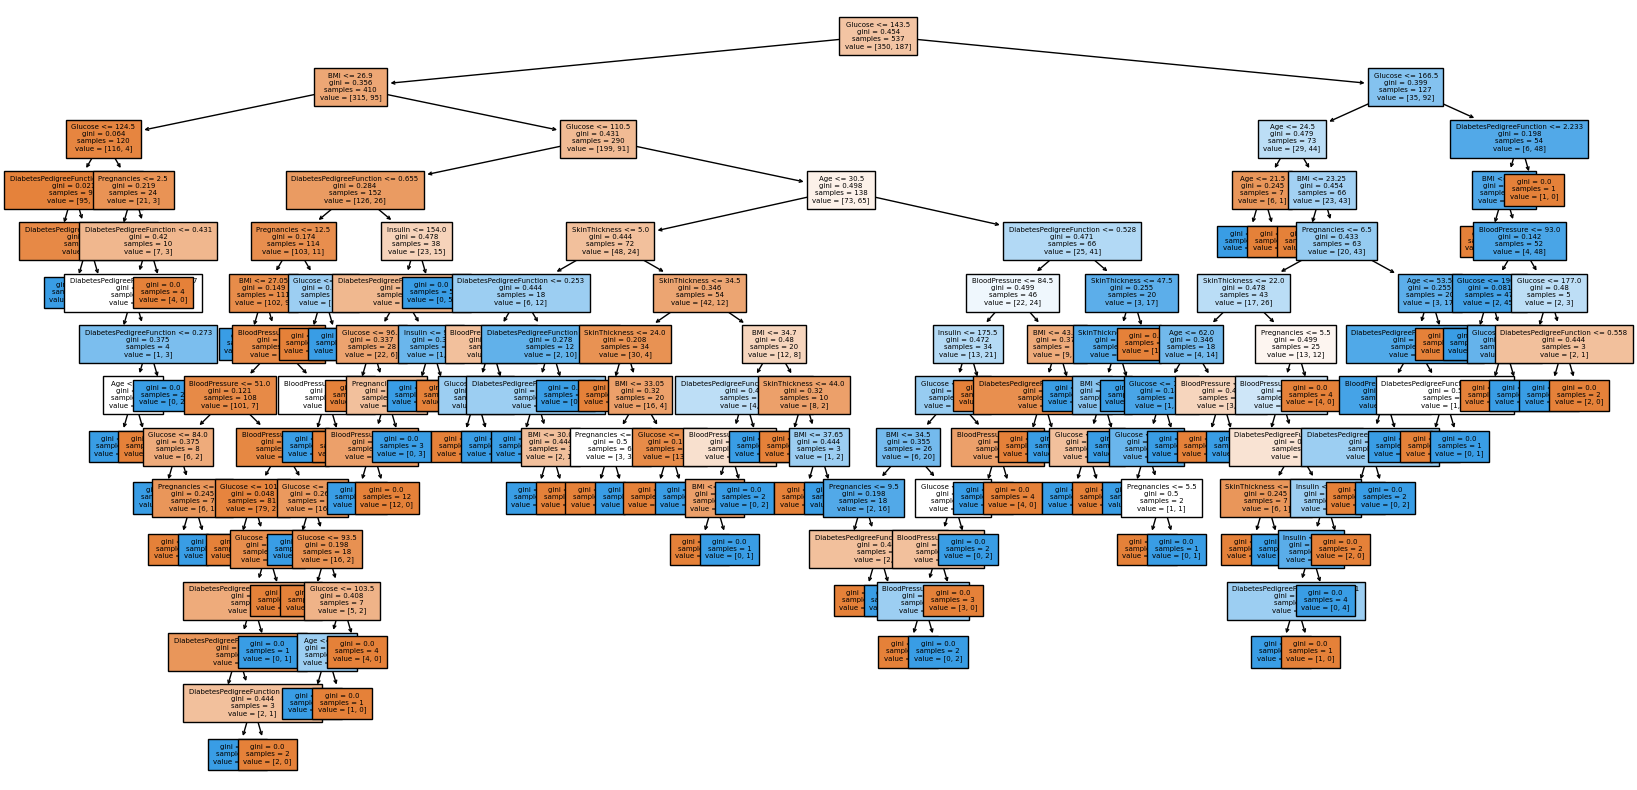

In [8]:

# Visualize the tree
plt.figure(figsize=(20, 10))
plot_tree(DTree_clf,
          filled=True,
          feature_names=X_train.columns,
          fontsize=5
         )
plt.show()

### kNN Classification

In [9]:
#create new a knn model
from sklearn.neighbors import KNeighborsClassifier

Knn_clf = KNeighborsClassifier(n_neighbors=3)
Knn_clf.fit(X_train,y_train)
Knn_pred = Knn_clf.predict(X_test)

print('knn: {}'.format(Knn_clf.score(X_test, y_test)))


knn: 0.7272727272727273


### Naive Bayes Classification

In [10]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB


NaiveBayes_clf = BernoulliNB() #naive bayes
NaiveBayes_clf.fit(X_train,y_train)
NaiveBayes_pred = NaiveBayes_clf.predict(X_test)

print('NB: {}'.format(NaiveBayes_clf.score(X_test, y_test)))

NB: 0.6493506493506493


We're now ready to start implementing ensemble classification methods.

Before we get into the big ensemble methods, let's cover a very quick and easy method of using an ensemble approach- averaging predictions. We simply add the different predicted values of our chosen classifiers together and then divide by the total number of classifiers, using floor division to get a whole value.

#### Simple Averaging Approach

In [11]:
#simple average classifier
# averaged_preds = ## write your code
averaged_preds = (NaiveBayes_pred + DTree_pred + Knn_pred)//3

acc = accuracy_score(y_test, averaged_preds)
print(acc)

0.6493506493506493


What do you think about this result? Should we try other classification model e.g., Logistic Regression?

### VotingClassifier

The VotingClassifier takes in a list of different estimators as arguments and a voting method. The `hard` voting method uses the predicted labels and a majority rules system, while the `soft` voting method predicts a label based on the argmax/largest predicted value of the sum of the predicted probabilities.

In [12]:
from sklearn.ensemble import VotingClassifier


#create a dictionary of our models
estimators=[('knn', Knn_clf), ('NaiveBayes', NaiveBayes_clf), ('DT', DTree_clf)]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
ensemble.fit(X_train, y_train)

#test our model on the test data
ensemble.score(X_test, y_test)

0.7186147186147186

What do you think about this result?

### Bagging

We will use inbuilt functions now from sklearn library. sklearn's BaggingClassifier takes in a chosen classification model as well as the number of estimators that you want to use - you can use a model like kNN, Naive Bayes or Decision Trees.

We'll compare several different bagging classification approaches here, printing out the mean results of the K-fold cross validation score

In [13]:
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings('ignore')

#bagging for various models
nb_bagging_model = BaggingClassifier(base_estimator=NaiveBayes_clf, n_estimators=50) #naive bayes bagging
knn_bagging_model = BaggingClassifier(base_estimator=Knn_clf, n_estimators=50) #knn bagging
dtree_bagging_model = BaggingClassifier(base_estimator=DTree_clf, n_estimators=50) #decision tree bagging

def bagging_ensemble(model, model_name):
    k_folds = KFold(n_splits=10)
    results = cross_val_score(model, X_train, y_train, cv=k_folds)
    print(f"{model_name}: {results.mean()}")

# Evaluate the bagging models
bagging_ensemble(nb_bagging_model, 'Naive Bayes Bagging')
bagging_ensemble(dtree_bagging_model, 'Decision Tree Bagging')
bagging_ensemble(knn_bagging_model, 'KNN Bagging')

Naive Bayes Bagging: 0.6460167714884696
Decision Tree Bagging: 0.743046820405311
KNN Bagging: 0.7038784067085955


### Random Forest


In [14]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier() #random forest bagging
bagging_ensemble(random_forest,"Random_Forest")

Random_Forest: 0.7617749825296996


How to find the best value of number of estimators in Random Forest?

In [15]:
from sklearn.model_selection import GridSearchCV


#create a new rf classifier
rf = RandomForestClassifier()

#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200]}

#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)

#fit model to training data
rf_gs.fit(X_train, y_train)

#save best model
rf_best = rf_gs.best_estimator_

#check best n_estimators value
print(rf_gs.best_params_)

{'n_estimators': 50}


In [16]:
bagging_ensemble(rf_best, "RF_best")

RF_best: 0.7486722571628233


Now you know that you can use GridSearchCV to find the best hyperparamter from the given set, can you use this for kNN classification model to find best k value?

In [17]:
#create new a knn model
# knn = # ...write your code
knn = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
# knn_gs = # ...write your code

knn_gs = GridSearchCV(knn, params_knn, cv=5)

#fit model to training data
knn_gs.fit(X_train, y_train)


#save best model
knn_best = knn_gs.best_estimator_

#check best n_neigbors value

print(knn_gs.best_params_)

bagging_ensemble(knn_best,"knn_best")

{'n_neighbors': 10}
knn_best: 0.7355345911949686


### AdaBoost
Scikit-Learn has a built-in AdaBoost classifier, which takes in a given number of estimators as the first argument.

In [18]:
from sklearn.ensemble import AdaBoostClassifier
ada_boost = AdaBoostClassifier(n_estimators=20, random_state=12)
ada_boost.fit(X_train, y_train)
ada_boost.score(X_test, y_test)

0.7229437229437229

 We can try using a for loop to see how the classification performance changes at different values, and we can also combine it with the K-Folds cross validation tool:

In [19]:
#adaboost - find better n_estimators
k_folds = KFold(n_splits=10)

num_estimators = [20, 40, 60, 80, 100]

for i in num_estimators:
    ada_boost = AdaBoostClassifier(n_estimators=i, random_state=12)
    results = cross_val_score(ada_boost, X_train, y_train, cv=k_folds)
    print("Results for {} estimators:".format(i))
    print(results.mean())

Results for 20 estimators:
0.7727812718378756
Results for 40 estimators:
0.7578616352201257
Results for 60 estimators:
0.759748427672956
Results for 80 estimators:
0.7430118798043327
Results for 100 estimators:
0.7429070580013976


### Other Popular Ensemble Classification Models

### Gradient Boosting

Gradient Boosting or GBM is another ensemble machine learning algorithm that works for both regression and classification problems. GBM uses the boosting technique, combining a number of weak learners to form a strong learner. Regression trees used as a base learner, each subsequent tree in series is built on the errors calculated by the previous tree

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7705627705627706

### XGBoost

GBoost (extreme Gradient Boosting) is an advanced implementation of the gradient boosting algorithm. XGBoost has proved to be a highly effective ML algorithm, extensively used in machine learning competitions and hackathons. XGBoost has high predictive power and is almost 10 times faster than the other gradient boosting techniques. It also includes a variety of regularization which reduces overfitting and improves overall performance. Hence it is also known as ‘regularized boosting‘ technique.

In [21]:
import xgboost as xgb

model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7272727272727273

Another popular boosting approach is `LightGBM` model. Light GBM beats all the other algorithms when the dataset is extremely large. Compared to the other algorithms, Light GBM takes lesser time to run on a huge dataset.
LightGBM is a gradient boosting framework that uses tree-based algorithms and follows leaf-wise approach while other algorithms work in a level-wise approach pattern.

#import lightgbm as lgb

### References
1. Pattern Recognition and Machine Learning, Christopher Bishop, New York, Springer,  2006.
2. https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a
3. Statistical Machine Learning Course Workshop, 2015, University of Melbourne, Australia
4. https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/